In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


In [ ]:
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from tqdm.notebook import tqdm
import supervision as sv
import numpy as np
from ultralytics import YOLO

VIDEO_PATH = '/content/drive/MyDrive/Стажировка/video_test/rakurs6.mp4'

RESULT_PATH = '/content/drive/MyDrive/Стажировка/video_test/RESULT/result6.mp4'

model_det = YOLO("/content/drive/MyDrive/Стажировка/weights/best_120e.pt")
model_seg = YOLO('yolov8s-seg.pt')

# Информация о видео
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

100%|██████████| 22.8M/22.8M [00:00<00:00, 155MB/s]


In [ ]:
print(video_info)

VideoInfo(width=1440, height=1080, fps=30, total_frames=1308)


In [ ]:
# Цвет Аннотатора

#color = sv.Color.from_hex("#f00")
color_palette = sv.ColorPalette.from_hex(["#0f0", "#00f", "#f00"])

# Цвет текста Аннотатора
text_color = sv.Color.from_hex("#0ff")

# Создаем трэкер
byte_tracker = sv.ByteTrack()

# Создаем Аннотатор
#label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_CENTER, color=color_palette, text_color=text_color, text_padding=2, text_thickness=1)
#corner_annotator = sv.BoxCornerAnnotator(color=color_palette, thickness=1)
#ellipse_annotator = sv.EllipseAnnotator(color=color, thickness=2)
#box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=2, text_scale=1)
triangle_annotator = sv.TriangleAnnotator(color = color_palette)

In [ ]:
# Продолжительность сек.
print(f'Res: {video_info.resolution_wh}, FPS: {video_info.fps}, Dur.: {video_info.total_frames//video_info.fps} sec.')

Res: (1440, 1080), FPS: 30, Dur.: 43 sec.


### Способ 1

In [ ]:
'''
Функция колбэка для обработки кадра
'''
def process_frame(frame: np.ndarray, _) -> np.ndarray:

    # Предсказание модели
    results = model(frame, imgsz=video_info.width, conf=0.4, verbose=False)[0]

    # Разбираем результат
    detections = sv.Detections.from_ultralytics(results)

    # Обновляем трэкер
    detections = byte_tracker.update_with_detections(detections)

    # Фильтр по номеру класса 2 - без каски
    detections = detections[np.isin(detections.class_id, [2,5])]

    # Формируем метку для Аннотатора
    #labels = [f"#{tracker_id} {confidence:.0%}" for _, _, confidence, _, tracker_id in detections]
    # labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _ in detections]

    # Аннотируем фрейм
    #frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=labels)
    frame = triangle_annotator.annotate(scene=frame, detections=detections)
    frame = ellipse_annotator.annotate(scene=frame, detections=detections)

    return frame

In [ ]:
# Обработка видео
sv.process_video(source_path=VIDEO_PATH, target_path=RESULT_PATH, callback=process_frame)

### Способ 2 с полигоном и трекером

In [ ]:
# Инициализируем полигон
polygon = np.array([
    [10, 10],
    [10, video_info.height-10],
    [video_info.width-10, video_info.height-10],
    [video_info.width-10, 10]
])

# Создаем зону
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)
# Создаем аннотатор зоны
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=5, text_thickness=2, text_scale=1)

# Создаем генератор фреймов
frames_generator = sv.get_video_frames_generator(VIDEO_PATH)
# Создаем итератор по генератору
frame_iterator = iter(frames_generator)

with sv.VideoSink(target_path=RESULT_PATH, video_info=video_info) as sink:
  # Прикрутим tqdm в цикл для вывода прогресса
  for frame in tqdm(frame_iterator, total=video_info.total_frames):

      # Предиктим
      result_det = model_det(frame, imgsz=video_info.width, verbose=False)[0]
      #result_seg = model_seg(frame, imgsz=video_info.width, verbose=False)[0]

      # Детектим
      detections = sv.Detections.from_ultralytics(result_det)

      #nh_detections = detections[np.isin(detections.class_id, [0,2])]
      detections = detections[np.isin(detections.class_id, [2])]
      detections = byte_tracker.update_with_detections(detections)
      zone.trigger(detections=detections)
      #labels = [f"id{tracker_id} {confidence:.0%}" for _, _, confidence, _, tracker_id in h_detections]

      #annotated_frame = label_annotator.annotate(scene=frame.copy(), detections=h_detections, labels=labels)

      annotated_frame = triangle_annotator.annotate(scene=frame.copy(), detections=detections)
      annotated_frame = zone_annotator.annotate(scene=annotated_frame.copy())
      #annotated_frame = ellipse_annotator.annotate(scene=annotated_frame.copy(), detections=p_detections)
      #annotated_frame = corner_annotator.annotate(scene=annotated_frame.copy(), detections=h_detections)

      sink.write_frame(frame=annotated_frame)

  0%|          | 0/1308 [00:00<?, ?it/s]

### Тест попытка объединить предсказания det и seg с целью добыть маску

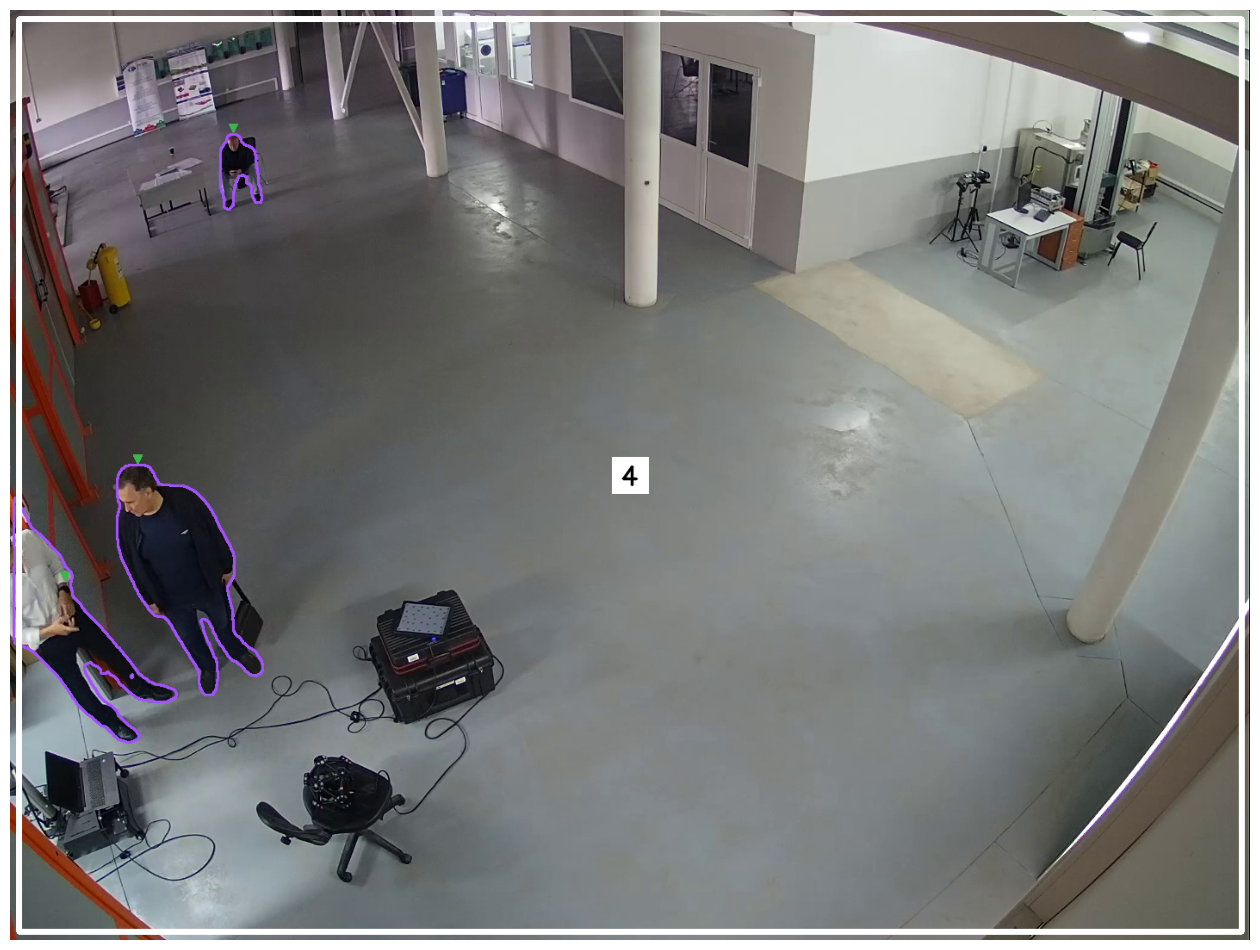

In [ ]:
# Инициализируем полигон
polygon = np.array([
    [10, 10],
    [10, video_info.height-10],
    [video_info.width-10, video_info.height-10],
    [video_info.width-10, 10]
])

zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# Создаем генератор фреймов
frames_generator = sv.get_video_frames_generator(VIDEO_PATH)
# Создаем итератор по генератору
iterator = iter(frames_generator)
frame = next(iterator)

# detect seg
results_seg = model_seg(frame, imgsz=video_info.width, verbose=False)[0]
detections_seg = sv.Detections.from_ultralytics(results_seg)
detections_seg = detections_seg[np.isin(detections_seg.class_id, 0)]
#print('Люди:', detections_seg.xyxy, len(detections_seg.xyxy))

# detect det
results_det = model_det(frame, imgsz=video_info.width, verbose=False)[0]
detections_det = sv.Detections.from_ultralytics(results_det)
detections_det = detections_det[np.isin(detections_det.class_id, 2)]
zone.trigger(detections=detections_det)
#print('Нет каски:', detections_det.xyxy, len(detections_det.xyxy))

#print(sv.box_iou_batch(detections_det.xyxy, detections_seg.xyxy,), len(sv.box_iou_batch(detections_det.xyxy, detections_seg.xyxy)))

# annotate
#halo_annotator = sv.HaloAnnotator()
polygon_annotator = sv.PolygonAnnotator()
triangle_annotator = sv.TriangleAnnotator()
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=5, text_thickness=2, text_scale=1)
#box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
#labels = [f"{model_seg.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _ in detections]
#frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = polygon_annotator.annotate(scene=frame.copy(), detections=detections_seg)
#frame = halo_annotator.annotate(scene=frame.copy(), detections=detections_seg)
frame = triangle_annotator.annotate(scene=frame.copy(), detections=detections_det)
frame = zone_annotator.annotate(scene=frame.copy())

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [ ]:
def is_iopa(ground_truth, pred, conf=.95):
    # Координаты области пересечения.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Высота и ширина пересечения.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    # Площадь пересечения
    area_of_intersection = i_height * i_width

    # Высота и ширина 'Основной Истины'
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Площадь 'Основной Истины'
    ground_truth_area = gt_height*gt_width

    # Высота и ширина Предсказания
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    # Площадь Прогноза
    pred_area = pd_height*pd_width

    # Площадь объединения
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    # IoU
    iou = area_of_intersection / area_of_union

    print(f'area_of_intersection={area_of_intersection},area_of_union={area_of_union}')

    print(f'Пересечение от площади={area_of_intersection/(pd_height*pd_width)}')

    return iou

In [ ]:
print('Нет каски:', detections_det.xyxy, len(detections_det.xyxy))

Нет каски: [[     118.72      526.88      178.24      595.52]
 [     126.88      527.49      170.55       557.9]
 [     49.505      662.78      78.431      711.32]
 [     253.01       142.8      266.39      153.18]] 4


In [ ]:
print('Люди:', detections_seg.xyxy, len(detections_seg.xyxy))

Люди: [[     120.16      527.83      293.45      796.61]
 [    0.13451      553.89      192.48      850.74]
 [     242.68      143.95      293.42      231.81]] 3


In [ ]:
for i in range(len(detections_seg.xyxy)):
  print('IoU=',get_iou(detections_seg.xyxy[0],detections_det.xyxy[i]),'\n')

ground_truth_area=47019.96719701588
pred_area=4214.620679419488
area_of_intersection=4057.877218136564,area_of_union=47176.710658298805
Пересечение от площади=0.9628095923202955
IoU= 0.08601441604370835 

ground_truth_area=47019.96719701588
pred_area=1402.9686664938927
area_of_intersection=1387.8534311056137,area_of_union=47035.08243240416
Пересечение от площади=0.9892262487757101
IoU= 0.029506771527405076 

ground_truth_area=47019.96719701588
pred_area=1482.5605282597244
area_of_intersection=0.0,area_of_union=48502.527725275606
Пересечение от площади=0.0
IoU= 0.0 

